# Train a Meta Neural Network on NASBench
## Predict the accuracy of neural networks to within one percent!

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# you may need to pip install nasbench
from nasbench import api

from nas_bench.data import NasbenchData
from meta_neural_net import MetaNeuralnet


W1022 21:38:01.895030 4477840704 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/nasbench/lib/training_time.py:130: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

W1022 21:38:01.895687 4477840704 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/nasbench/lib/training_time.py:174: The name tf.train.CheckpointSaverListener is deprecated. Please use tf.estimator.CheckpointSaverListener instead.

W1022 21:38:01.896151 4477840704 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/nasbench/lib/evaluate.py:30: The name tf.train.NanLossDuringTrainingError is deprecated. Please use tf.estimator.NanLossDuringTrainingError instead.



In [2]:
# define a function to plot the meta neural networks

def plot_meta_neuralnet(ytrain, train_pred, ytest, test_pred, max_disp=500, title=None):
    
    plt.scatter(ytrain[:max_disp], train_pred[:max_disp], label='training data', alpha=0.7, s=64)
    plt.scatter(ytest[:max_disp], test_pred[:max_disp], label = 'test data', alpha=0.7, marker='^')

    # axis limits
    plt.xlim((5, 15))
    plt.ylim((5, 15))
    ax_lim = np.array([np.min([plt.xlim()[0], plt.ylim()[0]]),
                    np.max([plt.xlim()[1], plt.ylim()[1]])])
    plt.xlim(ax_lim)
    plt.ylim(ax_lim)
    
    # 45-degree line
    plt.plot(ax_lim, ax_lim, 'k:') 
     
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('true percent error')
    plt.ylabel('predicted percent error')
    plt.show()

In [3]:
# load the NASBench dataset
# takes about 1 minute to load the nasbench dataset
search_space = NasbenchData()


W1022 21:38:08.433768 4477840704 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/nasbench/api.py:146: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Loading dataset from file... This may take a few minutes...
Loaded dataset in 48 seconds


In [4]:
# method which runs a meta neural network experiment
def meta_neuralnet_experiment(params, 
                              ns=[100, 500], 
                              num_ensemble=3, 
                              test_size=500):
    
    for n in ns:
        for encode_paths in [False, True]:

            train_data = search_space.generate_random_dataset(num=n, 
                                                encode_paths=encode_paths)
            xtrain = np.array([d[1] for d in train_data])
            ytrain = np.array([d[2] for d in train_data])

            test_data = search_space.generate_random_dataset(num=test_size, 
                                                encode_paths=encode_paths)
            xtest = np.array([d[1] for d in test_data])
            ytest = np.array([d[2] for d in test_data])

            train_errors = []
            test_errors = []
            meta_neuralnet = MetaNeuralnet()
            for _ in range(num_ensemble):            
                meta_neuralnet.fit(xtrain, ytrain, **params)
                train_pred = np.squeeze(meta_neuralnet.predict(xtrain))
                train_error = np.mean(abs(train_pred-ytrain))
                train_errors.append(train_error)
                test_pred = np.squeeze(meta_neuralnet.predict(xtest))        
                test_error = np.mean(abs(test_pred-ytest))
                test_errors.append(test_error)

            train_error = np.round(np.mean(train_errors, axis=0), 3)
            test_error = np.round(np.mean(test_errors, axis=0), 3)
            print('Meta neuralnet training size: {}, encode paths: {}'.format(n, encode_paths))
            print('Train error: {}, test error: {}'.format(train_error, test_error))

            if encode_paths:
                title = 'Path encoding, training set size {}'.format(n)
            else:
                title = 'Adjacency list encoding, training set size {}'.format(n)            

            plot_meta_neuralnet(ytrain, train_pred, ytest, test_pred, title=title)
            plt.show()

W1022 21:39:06.975268 4477840704 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Meta neuralnet training size: 100, encode paths: False
Train error: 0.503, test error: 2.515


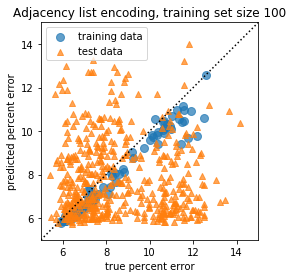

Meta neuralnet training size: 100, encode paths: True
Train error: 0.45, test error: 1.351


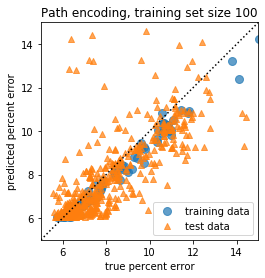

Meta neuralnet training size: 500, encode paths: False
Train error: 0.56, test error: 2.906


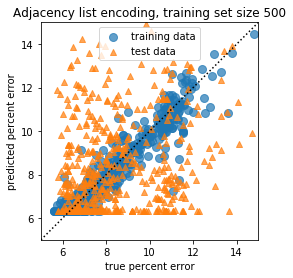

Meta neuralnet training size: 500, encode paths: True
Train error: 0.229, test error: 0.777


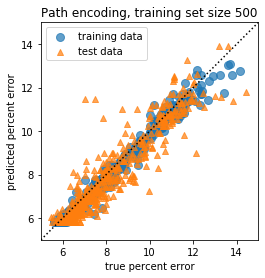

In [5]:
# try out your favorite hyperparameter settings to get the best accuracy on NASBench
meta_neuralnet_params = {'loss':'mae', 'num_layers':10, 'layer_width':20, 'epochs':200, \
                         'batch_size':32, 'lr':.01, 'regularization':0, 'verbose':0}
ns = [100, 500]

# takes about 1 minute
meta_neuralnet_experiment(meta_neuralnet_params, ns)